# vector-search

# Step 1: find embeddings

## Deliverables for this step:

1. A description of your dataset (1 paragraph)


This dataset was created by combining data from the [World Cities Dataset](https://www.kaggle.com/datasets/viswanathanc/world-cities-datasets) with web scraping techniques to obtain city-specific codes from Tripadvisor, which are not available elsewhere.
It includes city names and the top attractions with descriptions for each one of them.

2. A description of the process to generate embeddings, including the neural network topology and hyperparameters (1 paragraph + 1 figure)

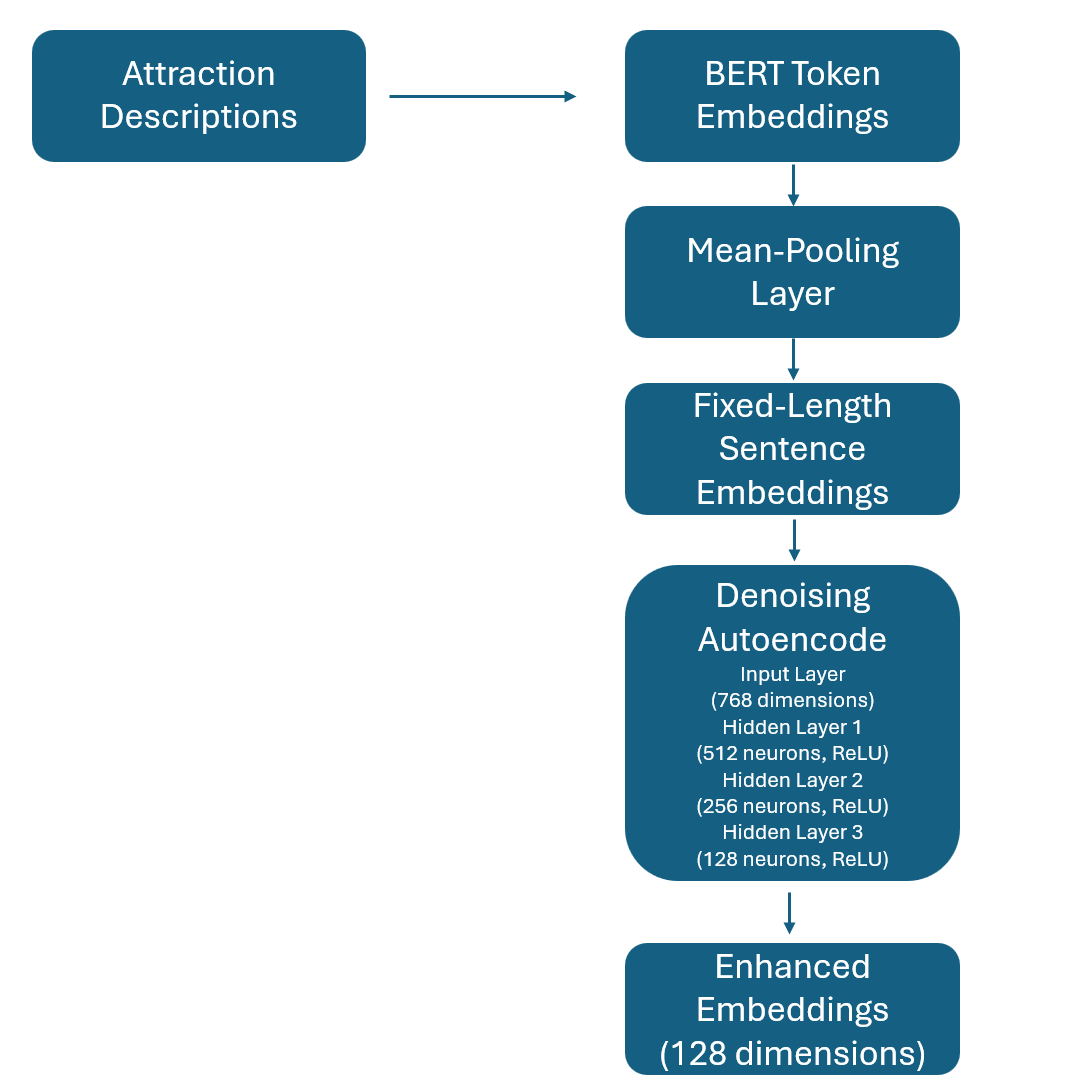

We generated embeddings for the attraction descriptions using BERT's pre-trained model to obtain token embeddings. We applied mean-pooling over the token embeddings to produce fixed-length sentence embeddings of 768 dimensions. Then, we trained a denoising autoencoder neural network with three hidden layers (512, 256, 128 neurons) to reduce the embedding dimensions and enhance relevance to our dataset. The model used ReLU activation functions and the Adam optimizer with a learning rate of 0.001.

3. A description of the training process, including a description of the loss function and why it makes sense to your problem (1 paragraph + 1 equation)

We trained the denoising autoencoder by corrupting the input embeddings with Gaussian noise. The network learned to reconstruct the original embeddings from the noisy inputs using the Mean Squared Error (MSE) loss function, defined as:

$$
L = \frac{1}{N} \sum_{i=1}^{N} (x_i - x'_i)^2
$$

where $x_i$ is the original embedding and $x'_i$ is the reconstructed embedding. This loss function minimized the difference between the original and reconstructed embeddings. It is appropriate because it encourages the model to learn robust representations that capture the essential features of the data.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

c:\Users\lorra\OneDrive\Área de Trabalho\Insper\24.2\NLP\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the dataset
data = pd.read_csv('../data/cleaned_dataset.csv')  

# Preprocess the text data
texts = data['Attractions'].tolist()

In [7]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()  # Set the model to evaluation mode


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [8]:
# Function to generate embeddings
def get_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state  # Token embeddings
        embeddings = embeddings.mean(dim=1)     # Mean pooling
    return embeddings.squeeze().cpu().numpy()

In [10]:
from tqdm import tqdm
# Generate embeddings for all texts with progress bar
embeddings = []
for text in tqdm(texts, desc="Generating embeddings"):
    emb = get_embedding(text)
    embeddings.append(emb)

embeddings = np.array(embeddings)

Generating embeddings: 100%|██████████| 1516/1516 [25:23<00:00,  1.00s/it]


In [11]:
# Add Gaussian noise for denoising autoencoder input
def add_noise(data, noise_factor=0.1):
    noisy_data = data + noise_factor * np.random.randn(*data.shape)
    return noisy_data

In [12]:
noisy_embeddings = add_noise(embeddings)

In [13]:
# Define the Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Prepare the dataset for PyTorch
class EmbeddingDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy_data = torch.tensor(noisy_data, dtype=torch.float32)
        self.clean_data = torch.tensor(clean_data, dtype=torch.float32)

    def __len__(self):
        return len(self.clean_data)

    def __getitem__(self, idx):
        return self.noisy_data[idx], self.clean_data[idx]

In [14]:
# Create dataset and dataloader
dataset = EmbeddingDataset(noisy_embeddings, embeddings)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [15]:
# Initialize the model, loss function, and optimizer
input_dim = embeddings.shape[1]
model = DenoisingAutoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    running_loss = 0.0
    for noisy_batch, clean_batch in dataloader:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)

        # Forward pass
        outputs = model(noisy_batch)
        loss = criterion(outputs, clean_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/50], Loss: 0.0200
Epoch [2/50], Loss: 0.0121
Epoch [3/50], Loss: 0.0098
Epoch [4/50], Loss: 0.0082
Epoch [5/50], Loss: 0.0074
Epoch [6/50], Loss: 0.0068
Epoch [7/50], Loss: 0.0065
Epoch [8/50], Loss: 0.0062
Epoch [9/50], Loss: 0.0059
Epoch [10/50], Loss: 0.0056
Epoch [11/50], Loss: 0.0053
Epoch [12/50], Loss: 0.0051
Epoch [13/50], Loss: 0.0050
Epoch [14/50], Loss: 0.0048
Epoch [15/50], Loss: 0.0047
Epoch [16/50], Loss: 0.0045
Epoch [17/50], Loss: 0.0045
Epoch [18/50], Loss: 0.0044
Epoch [19/50], Loss: 0.0043
Epoch [20/50], Loss: 0.0042
Epoch [21/50], Loss: 0.0041
Epoch [22/50], Loss: 0.0040
Epoch [23/50], Loss: 0.0040
Epoch [24/50], Loss: 0.0039
Epoch [25/50], Loss: 0.0038
Epoch [26/50], Loss: 0.0038
Epoch [27/50], Loss: 0.0037
Epoch [28/50], Loss: 0.0037
Epoch [29/50], Loss: 0.0036
Epoch [30/50], Loss: 0.0035
Epoch [31/50], Loss: 0.0034
Epoch [32/50], Loss: 0.0034
Epoch [33/50], Loss: 0.0034
Epoch [34/50], Loss: 0.0034
Epoch [35/50], Loss: 0.0033
Epoch [36/50], Loss: 0.0033
E

In [ ]:
# Save the trained encoder for future use
torch.save(model.encoder.state_dict(), 'encoder.pth')

In [2]:
!pip install torch torchvision transformers pandas numpy

  Using cached transformers-4.46.1-py3-none-any.whl.metadata (44 kB)
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached pillow-11.0.0-cp39-cp39-win_amd64.whl.metadata (9.3 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached regex-2024.9.11-cp39-cp39-win_amd64.whl.metadata (41 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached safetensors-0.4.5-cp39-none-win_amd64.whl.metadata (3.9 kB)
  Using cached tokenizers-0.20.1-cp39-none-win_amd64.whl.metadata (6.9 kB)
  Using cached tqdm-4.66.6-py3-none-any.

# Step 2: Visualize Your Embeddings
## Visualization with t-SNE
We projected the high-dimensional embeddings onto a 2D space using t-SNE for visualization. We applied this to both the pre-trained embeddings and the tuned embeddings from the denoising autoencoder. We used the scikit-learn implementation of t-SNE with default parameters.

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
!pip install matplotlib scikit-learn seaborn

C:\Users\lorra\AppData\Local\Temp\ipykernel_32340\1827049359.py:27: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 1487
  plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))


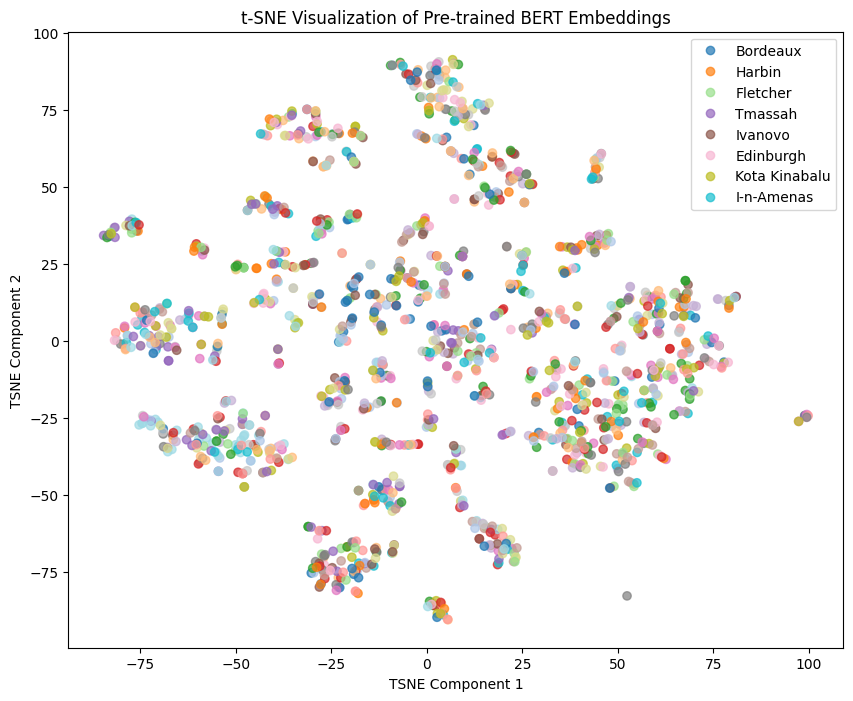

C:\Users\lorra\AppData\Local\Temp\ipykernel_32340\1827049359.py:27: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 1487
  plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))


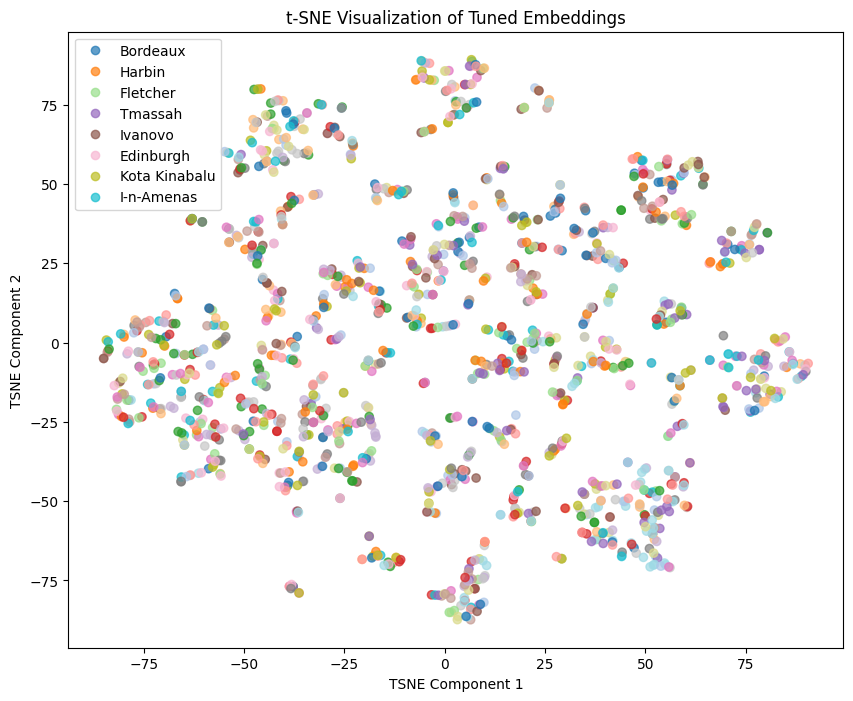

In [21]:
# Load the original embeddings (pre-trained BERT embeddings)
original_embeddings = embeddings  # From Step 1

# Load the tuned embeddings (after passing through the encoder)
model.encoder.eval()  # Set the encoder to evaluation mode
with torch.no_grad():
    tuned_embeddings = model.encoder(torch.tensor(embeddings, dtype=torch.float32).to(device)).cpu().numpy()

# Prepare labels for visualization (e.g., city names)
labels = data['City'].tolist()

# Function to perform t-SNE and plot
def visualize_embeddings(embeddings, title):
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create a DataFrame for easy plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'label': labels
    })
    
    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df['x'], df['y'], c=pd.Categorical(df['label']).codes, cmap='tab20', alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.show()

# Visualize original embeddings
visualize_embeddings(original_embeddings, 't-SNE Visualization of Pre-trained BERT Embeddings')

# Visualize tuned embeddings
visualize_embeddings(tuned_embeddings, 't-SNE Visualization of Tuned Embeddings')


In [22]:
# Load the original embeddings (pre-trained BERT embeddings)
original_embeddings = embeddings  # Replace this with the actual loading code if needed

# Generate tuned embeddings (after passing through your encoder)
model.encoder.eval()  # Set the encoder to evaluation mode
with torch.no_grad():
    tuned_embeddings = model.encoder(torch.tensor(embeddings, dtype=torch.float32)).cpu().numpy()

# Prepare labels for visualization (e.g., city names or document labels)
labels = data['City'].tolist()  # Adjust 'City' if your labels are different

In [23]:
# Apply t-SNE to both sets of embeddings
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
original_tsne = tsne.fit_transform(original_embeddings)
tuned_tsne = tsne.fit_transform(tuned_embeddings)

# Create DataFrames for easy manipulation and plotting
original_df = pd.DataFrame({
    'x': original_tsne[:, 0],
    'y': original_tsne[:, 1],
    'label': labels,
    'embedding_type': 'Pre-trained'
})

tuned_df = pd.DataFrame({
    'x': tuned_tsne[:, 0],
    'y': tuned_tsne[:, 1],
    'label': labels,
    'embedding_type': 'Tuned'
})

# Combine both DataFrames for easier plotting
combined_df = pd.concat([original_df, tuned_df], ignore_index=True)


In [29]:
!pip install plotly nbformat


In [31]:
# nbformat verison 
import nbformat
print(nbformat.__version__)

5.10.4


In [ ]:
import plotly.express as px

# Plot with Plotly, enabling color by label and hover information
fig = px.scatter(
    combined_df, x='x', y='y', color='label', 
    facet_col='embedding_type',  # Splits into two plots: Pre-trained vs. Tuned
    title="t-SNE Visualization of Embeddings",
    hover_data={'label': True, 'embedding_type': False}
)

# Customize hover and layout options for better readability
fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(
    title="Interactive t-SNE Visualization of Pre-trained and Tuned Embeddings",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2"
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:

fig.show()